# Split characters in image

In [1]:
from typing import Text, List, Tuple, Optional
from numbers import Number

import os
from pathlib import Path

import numpy as np
import cv2
from scipy.signal import convolve
from PIL import Image
import skimage

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def normalize(data: np.array) -> np.array:
    return (data - data.min())/(data.max()-data.min())

def load_image(path: Text, norm = True) -> np.array:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if norm:
        image = normalize(image)
    return image

def show_image(image: np.array, keypoints: Optional[List[Tuple[Number]]] = None, title: Optional[Text] = "", figsize: Optional[Tuple[Number]] = (12,4)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    ax.imshow(image, cmap="gray")
    if keypoints:
        left_kp = [kp[0] for kp in keypoints]
        right_kp = [kp[1] for kp in keypoints]
        ax.vlines(x = left_kp, ymin=0, ymax=image.shape[0] - 1, color = 'r')
        ax.vlines(x = right_kp, ymin=0, ymax=image.shape[0] - 1, color = 'g')   
    plt.show()

def show_signal(signal: np.array, title: Optional[Text] = "", figsize: Optional[Tuple[Number]] = (12,4)) -> np.array:
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(signal)
    plt.show()

def image2signal(image: np.array, axis = 0) -> np.array:
    return image.mean(axis=axis)

def binarize_signal(signal: np.array,  threshold = 0.9) -> np.array:
    return (signal > threshold).astype(np.uint8)

def get_crop_keypoints(signal: np.array, padding = 0) -> List[Tuple[Number]]:
    kernel_left = [-1, 1]
    kernel_right = [1, -1]
    signal_diff_left = convolve(signal, kernel_left)
    signal_diff_right = convolve(signal, kernel_right)

    # 8 keypoints to detect 7 elements
    # filter extreme points
    kp = 8
    left_kp = np.argpartition(signal_diff_left, -kp)[-kp:]
    left_kp = left_kp - padding
    left_kp[left_kp < 0] = 0
    left_kp = sorted(left_kp)[:-1]
    right_kp = np.argpartition(signal_diff_right, -kp)[-kp:]
    right_kp = right_kp + padding
    right_kp[right_kp > len(signal)] = len(signal)
    right_kp = sorted(right_kp)[1:]

    return list(map(lambda x: tuple(x), zip(left_kp, right_kp)))

def get_cropped_images(image: np.array, crop_keypoints: List[Tuple[Number]]) -> List[np.array]:
    return [image[:, kp[0]:kp[1]] for kp in crop_keypoints]  

def get_characters_from_plate(image: np.array, threshold = 0.9, padding = 0) -> List[np.array]:
    raw_signal = image2signal(image)
    binary_signal = binarize_signal(raw_signal, threshold)
    crop_kp = get_crop_keypoints(binary_signal, padding)
    character_image_list = get_cropped_images(image, crop_kp)
    return character_image_list


In [17]:
segmented_path = Path("images/segmentation")

for segmented_file in os.listdir(segmented_path):

    image_file = segmented_path / segmented_file
    plate = segmented_file.split("_")[0]
    char_list = [c for c in plate]

    print(f"{segmented_file} --> {plate}")

    image = load_image(image_file)
    raw_signal = image2signal(image)
    binary_signal = binarize_signal(raw_signal, threshold=0.95)
    padding =0
    crop_kp = get_crop_keypoints(binary_signal, padding)

    character_image_list = get_cropped_images(image, crop_kp)

    digit_path = Path(f"images/ocr/{plate}/digits/")
    digit_path.mkdir(parents=True, exist_ok=True)
    chars_path = Path(f"images/ocr/{plate}/chars/")
    chars_path.mkdir(parents=True, exist_ok=True)

    for n, char_image in enumerate(character_image_list):
        try:
            char_image = np.array(Image.fromarray(char_image).resize((28,28)))
            t = skimage.filters.threshold_otsu(char_image)
            image_bin = 255 * (char_image < t).astype(np.int32)
            if n < 4:
                cv2.imwrite(str(digit_path) + "/" + str(n) + "_" + char_list[n] + ".jpg", image_bin)
            else:
                cv2.imwrite(str(chars_path) + "/" + str(n) + "_" + char_list[n] + ".jpg", image_bin)
        except:
            error = f"Error processing {segmented_file}, character: {char_list[n]}"
            print(error)
            open(str(digit_path) + "/" + error, 'a').close()
    

2018ZGZ_segmentation_test.png --> 2018ZGZ
8061HBD_segmentation.jpg --> 8061HBD
2539HPR_segmentation.jpg --> 2539HPR
3362LKY_segmentation.jpg --> 3362LKY
2844LPW_segmentation.jpg --> 2844LPW
0070JTB_segmentation.jpg --> 0070JTB
4894JHK_segmentation.jpg --> 4894JHK
1621HRH_segmentation.jpg --> 1621HRH
6837JSG_segmentation.jpg --> 6837JSG
5861KSR_segmentation.jpg --> 5861KSR
7659FYF_segmentation.jpg --> 7659FYF
8804HDG_segmentation.jpg --> 8804HDG
Error processing 8804HDG_segmentation.jpg, character: 8
Error processing 8804HDG_segmentation.jpg, character: 8
Error processing 8804HDG_segmentation.jpg, character: 0
Error processing 8804HDG_segmentation.jpg, character: G
1935CTP_segmentation.jpg --> 1935CTP
8939JGZ_segmentation.jpg --> 8939JGZ


# TEST ZONE

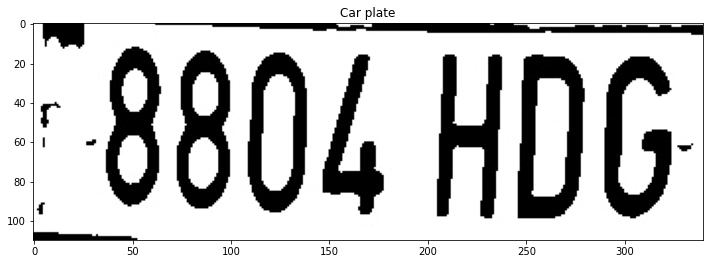

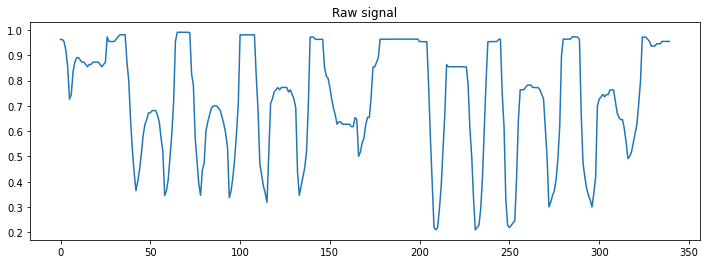

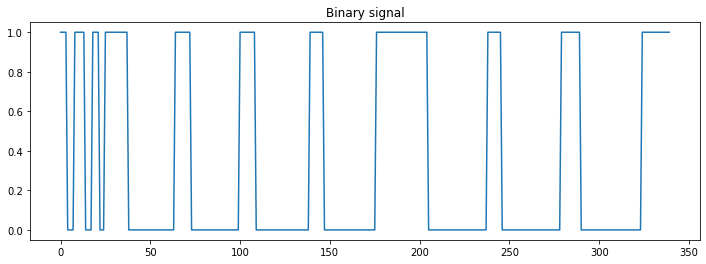

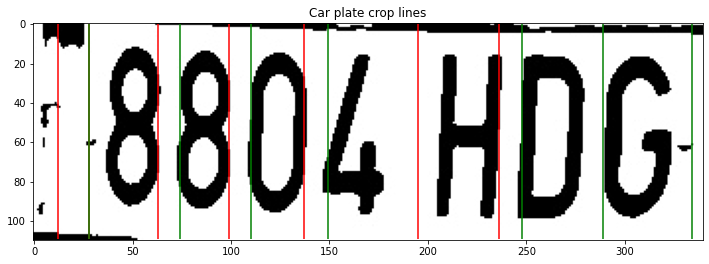

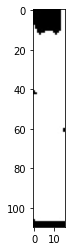

images/ocr/8804HDG/digits/8.jpg


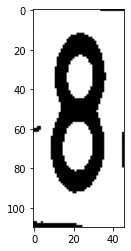

images/ocr/8804HDG/digits/8.jpg


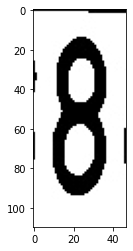

images/ocr/8804HDG/digits/0.jpg


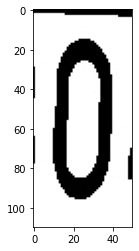

images/ocr/8804HDG/digits/4.jpg


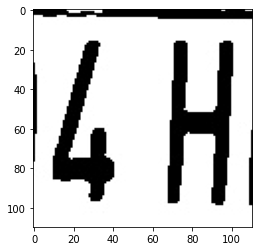

images/ocr/8804HDG/chars/H.jpg


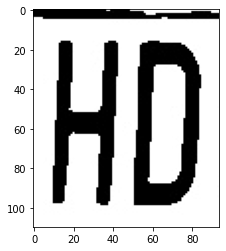

images/ocr/8804HDG/chars/D.jpg


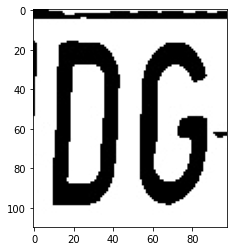

images/ocr/8804HDG/chars/G.jpg


In [14]:
image_file = "8804HDG_segmentation.jpg" #6837JSG
text = image_file.split("_")[0]
image_path = Path("images/segmentation") / image_file

image = load_image(image_path)
show_image(image, title="Car plate")
raw_signal = image2signal(image)
binary_signal = binarize_signal(raw_signal, threshold=0.87)
show_signal(raw_signal, "Raw signal")
show_signal(binary_signal, "Binary signal")
padding = 10
crop_kp = get_crop_keypoints(binary_signal, padding)
show_image(image, keypoints=crop_kp, title="Car plate crop lines")
character_image_list = get_cropped_images(image, crop_kp)
char_list = [c for c in text]
# os.mkdir(f"images/ocr/{text}")
# os.mkdir(f"images/ocr/{text}/digits/")
# os.mkdir(f"images/ocr/{text}/chars/")
for n, char_image in enumerate(character_image_list):
    show_image(char_image, figsize=(6,4))
    char_image = np.array(Image.fromarray(char_image).resize((28,28)))
    t = skimage.filters.threshold_otsu(char_image)
    image_bin = 255 * (char_image < t).astype(np.int32)
    if n <= 3:
        print(f"images/ocr/{text}/digits/" + char_list[n] + ".jpg")
        #cv2.imwrite(f"images/ocr/{text}/digits/" + str(n) + "_" + char_list[n] + ".jpg", image_bin)
    else:
        print(f"images/ocr/{text}/chars/" + char_list[n] + ".jpg")
        #cv2.imwrite(f"images/ocr/{text}/chars/" + str(n) + "_" + char_list[n] + ".jpg", image_bin)

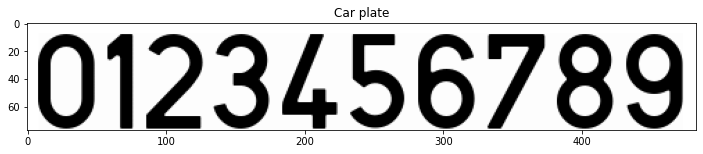

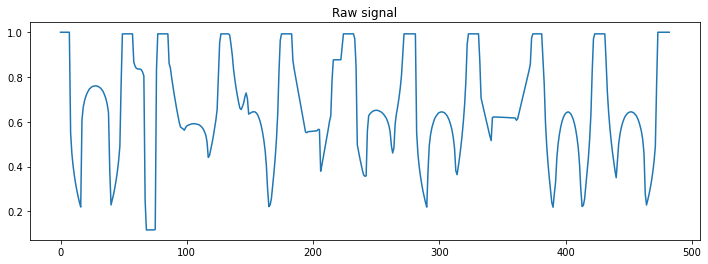

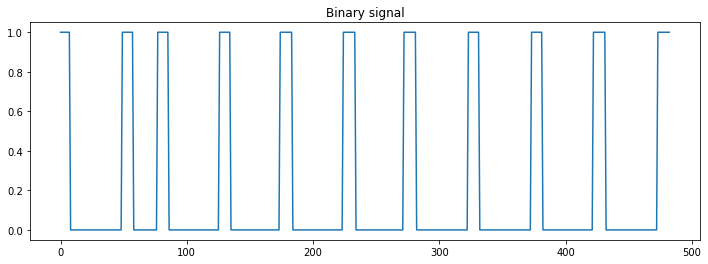

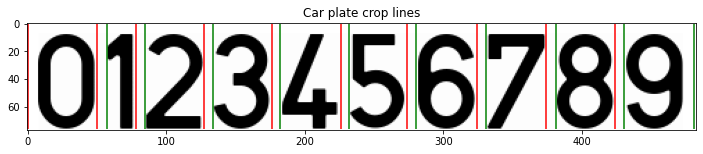

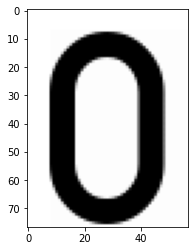

images/cluster/digits/0.jpg


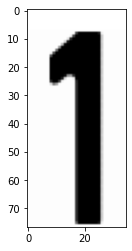

images/cluster/digits/1.jpg


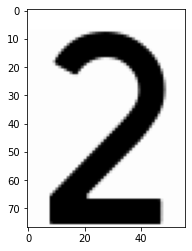

images/cluster/digits/2.jpg


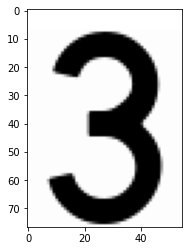

images/cluster/digits/3.jpg


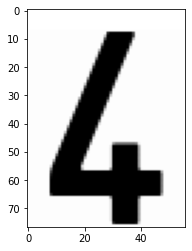

images/cluster/digits/4.jpg


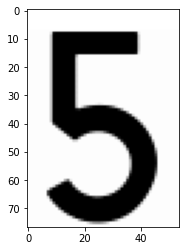

images/cluster/digits/5.jpg


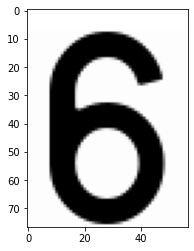

images/cluster/digits/6.jpg


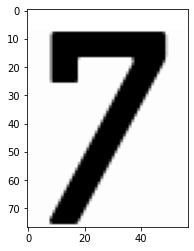

images/cluster/digits/7.jpg


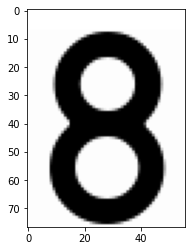

images/cluster/digits/8.jpg


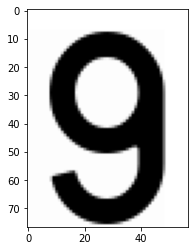

images/cluster/digits/9.jpg


In [19]:
image_file = "0123456789.png" #6837JSG
text = image_file.split("_")[0]
image_path = Path("images/cluster/digits") / image_file

image = load_image(image_path)
show_image(image, title="Car plate")
raw_signal = image2signal(image)
binary_signal = binarize_signal(raw_signal, threshold=0.95)
show_signal(raw_signal, "Raw signal")
show_signal(binary_signal, "Binary signal")
padding = 8

kernel_left = [-1, 1]
kernel_right = [1, -1]
signal_diff_left = convolve(binary_signal, kernel_left)
signal_diff_right = convolve(binary_signal, kernel_right)

# 8 keypoints to detect 7 elements
# filter extreme points
kp = 11
left_kp = np.argpartition(signal_diff_left, -kp)[-kp:]
left_kp = left_kp - padding
left_kp[left_kp < 0] = 0
left_kp = sorted(left_kp)[:-1]
right_kp = np.argpartition(signal_diff_right, -kp)[-kp:]
right_kp = right_kp + padding
right_kp[right_kp > len(binary_signal)] = len(binary_signal)
right_kp = sorted(right_kp)[1:]

crop_kp =  list(map(lambda x: tuple(x), zip(left_kp, right_kp)))

show_image(image, keypoints=crop_kp, title="Car plate crop lines")
character_image_list = get_cropped_images(image, crop_kp)
char_list = [c for c in text]
for n, char_image in enumerate(character_image_list):
    show_image(char_image, figsize=(6,4))
    char_image = np.array(Image.fromarray(char_image).resize((28,28)))
    t = skimage.filters.threshold_otsu(char_image)
    image_bin = 255 * (char_image < t).astype(np.int32)
    print(f"images/cluster/digits/" + char_list[n] + ".jpg")
    cv2.imwrite(f"images/cluster/digits/" + char_list[n] + ".jpg", image_bin)

# OCR model

## First idea - Use car plate dataset to train ocr model

In [386]:
import pandas as pd

import xml.etree.ElementTree as ET
from tqdm import tqdm

In [387]:
filenames = []
images = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [388]:
images_path = 'images/ocr/archive/images/'
annotations_path = 'images/ocr/archive/annotations/'
images_list = sorted(os.listdir(images_path))
annotations_list = sorted(os.listdir(annotations_path))
for file, image_file in tqdm(zip(annotations_list, images_list)):
    images.append(os.path.join(images_path, image_file))
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

433it [00:00, 10725.47it/s]


In [389]:
df = pd.DataFrame({
    'file':filenames,
    'image':images,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [390]:
df.head()

,file,image,width,height,xmin,ymin,xmax,ymax
0,images/ocr/archive/annotations/Cars0.xml,images/ocr/archive/images/Cars0.png,500,268,226,125,419,173
1,images/ocr/archive/annotations/Cars1.xml,images/ocr/archive/images/Cars1.png,400,248,134,128,262,160
2,images/ocr/archive/annotations/Cars10.xml,images/ocr/archive/images/Cars10.png,400,225,140,5,303,148
3,images/ocr/archive/annotations/Cars100.xml,images/ocr/archive/images/Cars100.png,400,267,175,114,214,131
4,images/ocr/archive/annotations/Cars101.xml,images/ocr/archive/images/Cars101.png,400,300,167,202,240,220


In [391]:
df[["xmin", "ymin", "xmax", "ymax"]].values

array([[226, 125, 419, 173],
       [134, 128, 262, 160],
       [140,   5, 303, 148],
       ...,
       [ 98, 102, 297, 191],
       [ 85, 196, 247, 259],
       [ 70, 198, 262, 271]])

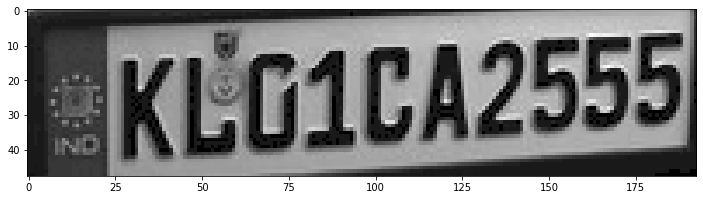

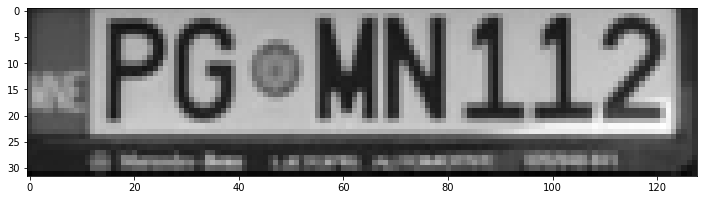

In [395]:
n_break = 1
for image_file, (xmin, ymin, xmax, ymax) in zip(df["image"].values, df[["xmin", "ymin", "xmax", "ymax"]].values):
    image = load_image(image_file)
    crop_image = image[ymin:ymax, xmin:xmax]
    show_image(crop_image)
    n_break += 1
    if n_break > 2:
        break

In [396]:
char_img = get_characters_from_plate(crop_image)

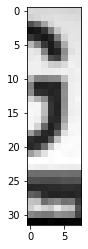

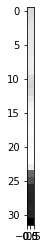

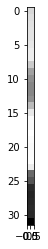

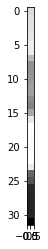

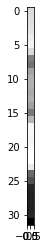

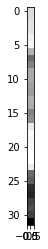

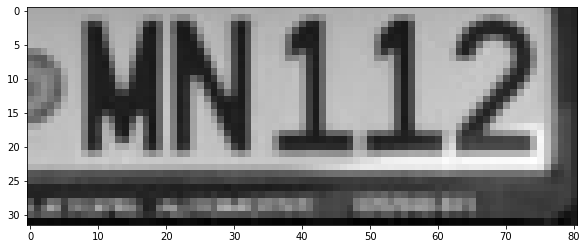

In [397]:
character_image_list = get_characters_from_plate(crop_image)
for char_image in character_image_list:
    show_image(char_image)

## Second idea - Use EMNIST dataset and cluster

In [399]:
!pip install emnist

In [400]:
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [515]:
from emnist import extract_training_samples

x_train, y_train = extract_training_samples('digits')
x_train.shape, y_train.shape

((240000, 28, 28), (240000,))

In [516]:
from emnist import extract_test_samples

x_test, y_test = extract_test_samples('digits')
x_test.shape, y_test.shape

((40000, 28, 28), (40000,))

In [517]:
x_train = normalize(x_train)
x_test = normalize(x_test)

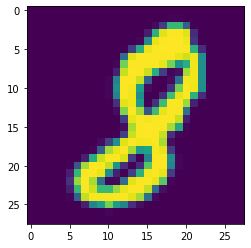

In [520]:
plt.imshow(x_train[0])

In [527]:
from skimage.filters import threshold_otsu

for i in range(len(x_train)):
    thr = threshold_otsu(x_train[i])
    x_train[i] = (x_train[i] > thr).astype(np.int32)

In [529]:
for i in range(len(x_test)):
    thr = threshold_otsu(x_test[i])
    x_test[i] = (x_test[i] > thr).astype(np.int32)

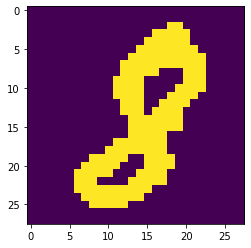

In [528]:
plt.imshow(x_train[0])

In [530]:
import annoy

f = 28 * 28

t = annoy.AnnoyIndex(f, 'angular')
for i in range(len(x_train)):
    image_flat = x_train[i].flatten()
    t.add_item(i, image_flat)

t.build(10)

True

In [532]:
image_test_flat = x_test[50].flatten()
pred = t.get_nns_by_vector(image_test_flat, 1)

In [497]:
y_train[pred], y_test[50]

(array([7], dtype=uint8), 2)

In [533]:
from sklearn.metrics import accuracy_score

def test(model, x_test, y_test, y_train):
    pred_list = []
    for i in range(len(x_test)):
        image_test_flat = x_test[i].flatten()
        pred_idx = model.get_nns_by_vector(image_test_flat, 1)[0]
        pred = y_train[pred_idx]
        pred_list.append(pred)
    acc = accuracy_score(pred_list, y_test)
    print(acc)
    

In [534]:
test(t, x_test, y_test, y_train)

0.971525


In [538]:
t.save('models/digit_model_binary.ann')

True

In [539]:
import pickle

with open('models/digit_model_binary_labels.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('models/digit_model_binary_labels.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(y_train == b)

[ True  True  True ...  True  True  True]


In [540]:
u = annoy.AnnoyIndex(28 * 28, 'angular')
u.load('models/digit_model_binary.ann')

True

In [541]:
test(u, x_test, y_test, y_train)

0.971525


Experiment results:

- Signals (binarized): 0.5596 accuracy
- Images: 0.977525 accuracy
- Images (binarized): 0.971525 accuracy

## Third Idea - Use our data and cluster with that

In [146]:
def get_descriptors(image):
    return image.flatten()

In [147]:
def generate_input_target_data(data_path, norm=False):
    x = []
    y = []
    for file in data_path:
        label = file.split(".")[0][-1].upper()
        image = load_image(file, norm=norm)
        descriptor = get_descriptors(image)
        x.append(descriptor)
        y.append(label)
    return x, y    

In [148]:
def create_model(x_train, y_train):
    f = x_train[0].shape[-1] #784

    t = annoy.AnnoyIndex(f, 'angular')
    for i in range(len(x_train)):
        image_descriptor = x_train[i]
        t.add_item(i, image_descriptor)

    t.build(10)
    return t

In [149]:
import pickle

def save_model(model, classes, model_name):
    model.save(f"models/{model_name}.ann")
    with open(f'models/{model_name}_labels.pickle', 'wb') as handle:
        pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [150]:
def load_model(model_name, f=784):
    model = annoy.AnnoyIndex(f, 'angular')
    model.load(f'models/{model_name}.ann')
    with open(f'models/{model_name}_labels.pickle', 'rb') as handle:
        cluster_labels = pickle.load(handle)
    return model, cluster_labels

In [151]:
from sklearn.metrics import accuracy_score

def validate_model(model, x_test, y_test, y_train):
    pred_list = []
    for i in range(len(x_test)):
        image_test_flat = x_test[i].flatten()
        pred_idx = model.get_nns_by_vector(image_test_flat, 20)[0]
        pred = y_train[pred_idx]
        pred_list.append(pred)
    print("Predictions:", pred_list)
    print("Target:", y_test)
    acc = accuracy_score(pred_list, y_test)
    print("Accuracy:", acc)

### Digits model

In [152]:
import glob

ocr_digits_path_list = [filename for filename in glob.iglob("images/ocr/*/digits/*.jpg", recursive=True)]

cluster_digits_path_list = [filename for filename in glob.iglob("images/cluster/digits/*.jpg", recursive=True)]

digits_path_list = ocr_digits_path_list + cluster_digits_path_list

In [153]:
x_train, y_train = generate_input_target_data(digits_path_list)

In [154]:
digit_model = create_model(x_train, y_train)

In [155]:
save_model(digit_model, y_train, "digit_model")

In [156]:
model, cluster_labels = load_model("digit_model", 784)

In [157]:
x_test, y_test = generate_input_target_data(digits_path_list)

In [158]:
validate_model(digit_model, x_test, y_test, y_train)

Predictions: ['4', '7', '8', '6', '3', '3', '6', '3', '2', '9', '9', '3', '8', '1', '6', '2', '1', '4', '8', '2', '4', '1', '6', '0', '8', '9', '5', '3', '1', '1', '5', '8', '6', '1', '8', '0', '2', '0', '0', '7', '0', '8', '4', '9', '4', '5', '6', '9', '7', '9', '3', '2', '5', '0', '4', '2', '6', '3', '7', '8', '1', '5', '9']
Target: ['4', '7', '8', '6', '3', '3', '6', '3', '2', '9', '9', '3', '8', '1', '6', '2', '1', '4', '8', '2', '4', '1', '6', '0', '8', '9', '5', '3', '1', '1', '5', '8', '6', '1', '8', '0', '2', '0', '0', '7', '0', '8', '4', '9', '4', '5', '6', '9', '7', '9', '3', '2', '5', '0', '4', '2', '6', '3', '7', '8', '1', '5', '9']
Accuracy: 1.0


### Chars model

In [159]:
ocr_chars_path_list = [filename for filename in glob.iglob("images/ocr/*/chars/*.jpg", recursive=True)]

cluster_chars_path_list = [filename for filename in glob.iglob("images/cluster/chars/*.jpg", recursive=True)]

chars_path_list = ocr_chars_path_list + cluster_chars_path_list

In [160]:
x_train, y_train = generate_input_target_data(chars_path_list)

In [161]:
chars_model = create_model(x_train, y_train)

In [162]:
save_model(chars_model, y_train, "chars_model")

In [163]:
model, cluster_labels = load_model("chars_model", 784)

In [164]:
x_test, y_test = generate_input_target_data(chars_path_list)

In [165]:
validate_model(chars_model, x_test, y_test, y_train)

Predictions: ['D', 'H', 'J', 'S', 'G', 'K', 'Y', 'L', 'J', 'G', 'Z', 'H', 'R', 'H', 'W', 'P', 'L', 'B', 'D', 'H', 'T', 'P', 'C', 'R', 'S', 'K', 'G', 'Z', 'Z', 'T', 'J', 'B', 'J', 'K', 'H', 'Y', 'F', 'F', 'R', 'P', 'H', 'N', 'K', 'C', 'X', 'V', 'G', 'I', 'B', 'Z', 'E', 'R', 'H', 'D', 'S', 'Y', 'T', 'L', 'F', 'J', 'O', 'Q', 'M', 'P', 'W', 'U', 'A']
Target: ['D', 'H', 'J', 'S', 'G', 'K', 'Y', 'L', 'J', 'G', 'Z', 'H', 'R', 'H', 'W', 'P', 'L', 'B', 'D', 'H', 'T', 'P', 'C', 'R', 'S', 'K', 'G', 'Z', 'Z', 'T', 'J', 'B', 'J', 'K', 'H', 'Y', 'F', 'F', 'R', 'P', 'H', 'N', 'K', 'C', 'X', 'V', 'G', 'I', 'B', 'Z', 'E', 'R', 'H', 'D', 'S', 'Y', 'T', 'L', 'F', 'J', 'O', 'Q', 'M', 'P', 'W', 'U', 'A']
Accuracy: 1.0
